# Create a PDF of the Data Quality Report for Data Desginer

# 🎛️ Import things

In [3]:
import os
from pprint import pprint

from datasets import load_dataset

from navigator_helpers.llms.llm_suite import GretelLLMSuite
from navigator_helpers.tasks.evaluation.evaluation import (
    BaseEvaluationTaskSuite,
    VisualizationTaskSuite
)

# set environment variable 'GRETEL_PROD_API_KEY' from https://console.gretel.ai/users/me/key
gretel_prod_api_key = input("Enter your Gretel API key from https://console.gretel.ai/users/me/key: ")
os.environ['GRETEL_PROD_API_KEY'] = gretel_prod_api_key

# 🔢 Choose Dataset for Evaluation

In [4]:
# Set the number of samples to load from the dataset for testing
# Set to None to use the full dataset
NUM_SAMPLES = 1000

datasets_dict = {
    "synthetic_text_to_sql": {
        "dataset_kwargs": {
            "path": "gretelai/synthetic_text_to_sql",
            "split": "train"
        },
        "code_lang": "sql",
        "eval_kwargs":{
            "instruction_col_name": "sql_prompt",
            "code_col_name": "sql",
            "context_col_name": "sql_context"
        }
    },
    "gsm8k": {
        "dataset_kwargs": {
            "path": "openai/gsm8k",
            "name": "main",
            "split": "train"
        },
        "eval_kwargs": {
            "instruction_col_name": "question",
            "code_col_name": "answer",
        }
    },
    "synthetic_gsm8k": {
        "dataset_kwargs": {
            "path": "gretelai/synthetic-gsm8k-reflection-405b",
            "split": "train"
        },
        "eval_kwargs": {
            "instruction_col_name": "question",
            "code_col_name": "answer",
        }
    },
    "xlcost_text_to_code": {
        "dataset_kwargs": {
            "path": "codeparrot/xlcost-text-to-code",
            "split": "train"
        },
        "code_lang": "python",
        "eval_kwargs": {
            "instruction_col_name": "text",
            "code_col_name": "code",
        }
    },
}

# Prompt user to select a dataset
print("Available datasets:")
for key in datasets_dict.keys():
    print(f" - {key}")

selected_dataset = input("\nEnter the name of the dataset to load: ").strip()

# Load the selected dataset
if selected_dataset in datasets_dict:
    dataset_dict = datasets_dict[selected_dataset]
    eval_kwargs = dataset_dict["eval_kwargs"]
    code_lang = dataset_dict["code_lang"] if "code_lang" in dataset_dict.keys() else None
    dataset = load_dataset(**dataset_dict["dataset_kwargs"])

    # Optionally, select a subset if NUM_SAMPLES is specified
    if NUM_SAMPLES is not None and NUM_SAMPLES < len(dataset):
        dataset = dataset.select(range(NUM_SAMPLES))
    
    dataset_df = dataset.to_pandas()
    
    print(f"Loaded dataset '{selected_dataset}' successfully!")
else:
    print("Error: Dataset not found. Please enter a valid dataset name.")

Available datasets:
 - synthetic_text_to_sql
 - gsm8k
 - synthetic_gsm8k
 - xlcost_text_to_code
Loaded dataset 'synthetic_text_to_sql' successfully!


## Run Evaluation on dataset

In [5]:
llm_suite = GretelLLMSuite()

2024-10-22 14:12:40.735 - INFO - 🦜 Initializing LLM suite
2024-10-22 14:12:40.740 - INFO - 📖 Natural language LLM: gretelai-mistral-nemo-2407
2024-10-22 14:12:40.743 - INFO - 💻 Code LLM: gretelai-mistral-nemo-2407
2024-10-22 14:12:40.745 - INFO - ⚖️ Judge LLM: gretelai-mistral-nemo-2407


In [6]:
# Define a dictionary to store evaluation results
results = {}

# Uncomment the following lines to run individual evaluation tasks
results.update({"row_uniqueness": BaseEvaluationTaskSuite(llm_suite, dataset_df).row_uniqueness()})
results.update({"feature_cardinality": BaseEvaluationTaskSuite(llm_suite, dataset_df).feature_cardinality()})
results.update({"feature_distribution": BaseEvaluationTaskSuite(llm_suite, dataset_df).feature_distribution()})
results.update({"num_words_per_record": BaseEvaluationTaskSuite(llm_suite, dataset_df).num_words_per_record()})

# Uncomment this line to run everything, including LLM-as-a-judge
# results = BaseEvaluationTaskSuite(llm_suite, dataset_df, code_lang, eval_kwargs).evaluate_all()

pprint(results)


{'feature_cardinality': {'domain': 100,
                         'domain_description': 100,
                         'id': 1000,
                         'sql': 1000,
                         'sql_complexity': 8,
                         'sql_complexity_description': 8,
                         'sql_context': 996,
                         'sql_explanation': 1000,
                         'sql_prompt': 1000,
                         'sql_task_type': 4,
                         'sql_task_type_description': 4},
 'feature_distribution': {'column_data_types': {'domain': 'Categorical',
                                                'domain_description': 'Categorical',
                                                'id': 'Other',
                                                'sql': 'Text',
                                                'sql_complexity': 'Categorical',
                                                'sql_complexity_description': 'Categorical',
                            

In [50]:
# Standard library imports
from typing import List, Optional, Tuple, Union, Dict, Any
import math
import io

# Third-party imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.io import to_image
from PIL import Image as PILImage
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, PageBreak, Paragraph, Spacer, Image, Table, TableStyle
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib import colors
from reportlab.lib.units import inch
from reportlab.lib.enums import TA_CENTER

# Constants
FIG_WIDTH = 7  # inches
FIG_HEIGHT = 3.6  # inches
SCORE_VALUES = [
    {"label": "Very poor", "color": "rgb(229, 60, 26)"},
    {"label": "Poor", "color": "rgb(229, 128, 26)"},
    {"label": "Average", "color": "rgb(229, 161, 26)"},
    {"label": "Good", "color": "rgb(183, 210, 45)"},
    {"label": "Excellent", "color": "rgb(72, 210, 45)"},
]
PRIMARY_PALETTE = ['#2E1065', '#D3A66E', '#110420', '#4F00A9', '#F9EFDE', '#1D0B32', '#8D32FA', '#C399FF', '#EFE5FF', '#EFD7AD', '#F4E3C6', '#FBF7ED', '#A59DAD', '#D2CED6', '#E8E7EB']
SECONDARY_PALETTE = ['#052095', '#FF6BA9', '#3056F2', '#FFA8CC', '#8BB9FF', '#FFEDF5', '#E5F0FF', '#1E9C98', '#92F6F4', '#C5FEFF', '#E8FEFF', '#FF9248', '#FFB38A', '#FFD7B5', '#FFECDC', '#FF6700', '#FFCA1A', '#FFE16D', '#FFF099', '#FFFDE3', '#ECA10A']

# Set up custom color palette for seaborn
sns.set_theme(style="white")
sns.set_palette(sns.color_palette(SECONDARY_PALETTE))

def create_chart(data: pd.Series, title: str, xlabel: str, ylabel: str) -> Image:
    fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_HEIGHT))
    bars = ax.bar(range(len(data)), data.values, color='#4F00A9')
    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')
    
    ax.set_title(title, fontsize=10, color='#1D0B32')
    ax.set_xlabel(xlabel, fontsize=10, color='#1D0B32')
    ax.set_ylabel(ylabel, fontsize=10, color='#1D0B32')
    ax.set_xticks(range(len(data)))
    
    truncated_labels = [str(label)[:17] + '...' if len(str(label)) > 20 else str(label) for label in data.index]
    ax.set_xticklabels(truncated_labels, rotation=45, ha='right', fontsize=8, color='#1D0B32')
    
    ax.tick_params(axis='both', colors='#1D0B32')
    ax.tick_params(axis='y', labelsize=6)
    
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}' if isinstance(height, float) else f'{height}',
                ha='center', va='bottom', fontsize=8, color='#1D0B32')
    
    plt.tight_layout()
    img_buffer = io.BytesIO()
    plt.savefig(img_buffer, format='png', dpi=300, bbox_inches='tight')
    img_buffer.seek(0)
    return Image(img_buffer, width=7*inch, height=4*inch)

def create_pareto_chart(data: pd.DataFrame, title: str) -> Image:
    fig, ax1 = plt.subplots(figsize=(FIG_WIDTH, FIG_HEIGHT))
    ax2 = ax1.twinx()
    
    bars = ax1.bar(range(len(data)), data['count'], color='#4F00A9')
    ax1.set_facecolor('white')
    fig.patch.set_facecolor('white')
    
    ax1.set_xlabel('Categories', fontsize=10, color='#1D0B32')
    ax1.set_ylabel('Count', fontsize=10, color='#1D0B32')
    ax1.set_title(title, fontsize=10, color='#1D0B32')
    
    cumulative_percentage = 100 * data['count'].cumsum() / data['count'].sum()
    ax2.plot(range(len(data)), cumulative_percentage, color='#FF6700', marker='D', ms=4)
    ax2.set_ylabel('Cumulative Percentage', fontsize=10, color='#1D0B32')
    ax2.set_ylim([0, 110])
    
    ax1.tick_params(axis='both', colors='#1D0B32')
    ax2.tick_params(axis='both', colors='#1D0B32')
    ax1.tick_params(axis='y', labelsize=6)
    ax2.tick_params(axis='y', labelsize=6)
    
    ax1.set_xticks(range(len(data)))
    truncated_labels = [str(label)[:25] + ('...' if len(str(label)) > 25 else '') for label in data.index]
    ax1.set_xticklabels(truncated_labels, rotation=45, ha='right', fontsize=6, color='#1D0B32')
    
    for i, v in enumerate(data['count']):
        ax1.text(i, v, f'{v:.2f}' if isinstance(v, float) else f'{v}', ha='center', va='bottom', fontsize=8, color='#1D0B32')
    
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}%'))
    
    plt.tight_layout()
    img_buffer = io.BytesIO()
    plt.savefig(img_buffer, format='png', dpi=300, bbox_inches='tight')
    img_buffer.seek(0)
    return Image(img_buffer, width=FIG_WIDTH*inch, height=FIG_HEIGHT*inch)

def create_text_diversity_chart(text_diversity_df: pd.DataFrame) -> Image:
    plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))
    ax = sns.barplot(x=text_diversity_df.index, y='diversity_index', data=text_diversity_df, color='#4F00A9')
    ax.set_facecolor('white')
    plt.gcf().patch.set_facecolor('white')
    
    plt.title("Text Diversity Indices", fontsize=10, color='#1D0B32')
    plt.ylabel("Diversity Index", fontsize=10, color='#1D0B32')
    plt.xlabel("", fontsize=10, color='#1D0B32')
    plt.xticks(rotation=45, ha='right', fontsize=8, color='#1D0B32')
    
    plt.ylim(0, 1)
    
    ax.tick_params(axis='both', colors='#1D0B32')
    ax.tick_params(axis='y', labelsize=6)
    
    for i, v in enumerate(text_diversity_df['diversity_index']):
        ax.text(i, v, f'{v:.2f}', ha='center', va='bottom', fontsize=8, color='#1D0B32')
    plt.tight_layout()
    
    img_buffer = io.BytesIO()
    plt.savefig(img_buffer, format='png', dpi=300, bbox_inches='tight')
    img_buffer.seek(0)
    return Image(img_buffer, width=7*inch, height=4*inch)

def create_schema_table(dataset_df: pd.DataFrame, data: Dict[str, Any]) -> Tuple[Table, Dict[str, float]]:
    schema_data = [['Column Name', 'Data Type', 'Total Count', '% Null', 'Average Length', 'Avg Tokens']]
    for col in dataset_df.columns:
        dtype = str(dataset_df[col].dtype)
        total_count = len(dataset_df)
        null_count = dataset_df[col].isnull().sum()
        pcnt_null = (null_count / total_count) * 100
        avg_length = 'N/A'
        avg_tokens = 'N/A'
        if 'feature_distribution' in data and 'distribution' in data['feature_distribution']:
            if col in data['feature_distribution']['distribution']:
                col_data = data['feature_distribution']['distribution'][col]
                if isinstance(col_data, dict):
                    if 'avg_length' in col_data:
                        avg_length = f"{col_data['avg_length']:.2f}"
                    if 'avg_tokens' in col_data:
                        avg_tokens = f"{col_data['avg_tokens']:.2f}"
        schema_data.append([col, dtype, total_count, f"{pcnt_null:.2f}%", avg_length, avg_tokens])
    
    table = Table(schema_data)
    style = TableStyle([
        ('BACKGROUND', (0, 0), (-1, 0), colors.HexColor('#4F00A9')),
        ('TEXTCOLOR', (0, 0), (-1, 0), colors.white),
        ('ALIGN', (0, 0), (-1, -1), 'LEFT'),
        ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
        ('FONTSIZE', (0, 0), (-1, 0), 8),
        ('BOTTOMPADDING', (0, 0), (-1, 0), 6),
        ('BACKGROUND', (0, 1), (-1, -1), colors.HexColor('#EFE5FF')),
        ('TEXTCOLOR', (0, 1), (-1, -1), colors.HexColor('#110420')),
        ('ALIGN', (0, 1), (-1, -1), 'LEFT'),
        ('FONTNAME', (0, 1), (-1, -1), 'Helvetica'),
        ('FONTSIZE', (0, 1), (-1, -1), 7),
        ('TOPPADDING', (0, 1), (-1, -1), 3),
        ('BOTTOMPADDING', (0, 1), (-1, -1), 3),
        ('GRID', (0, 0), (-1, -1), 1, colors.HexColor('#4F00A9'))
    ])
    table.setStyle(style)
    return table

def create_overview_table(overview_data: List[List[str]]) -> Table:
    table = Table(overview_data, colWidths=[1.5*inch, 1.5*inch])
    style = TableStyle([
        ('BACKGROUND', (0, 0), (-1, 0), colors.HexColor('#4F00A9')),
        ('TEXTCOLOR', (0, 0), (-1, 0), colors.white),
        ('ALIGN', (0, 0), (-1, -1), 'LEFT'),
        ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
        ('FONTSIZE', (0, 0), (-1, 0), 8),
        ('BOTTOMPADDING', (0, 0), (-1, 0), 3),  # Reduced padding
        ('BACKGROUND', (0, 1), (-1, -1), colors.HexColor('#EFE5FF')),
        ('TEXTCOLOR', (0, 1), (-1, -1), colors.HexColor('#110420')),
        ('ALIGN', (0, 1), (-1, -1), 'LEFT'),
        ('FONTNAME', (0, 1), (-1, -1), 'Helvetica'),
        ('FONTSIZE', (0, 1), (-1, -1), 7),
        ('TOPPADDING', (0, 1), (-1, -1), 3),  # Minimal top padding
        ('BOTTOMPADDING', (0, 1), (-1, -1), 3),  # Minimal bottom padding
        ('GRID', (0, 0), (-1, -1), 0.5, colors.HexColor('#4F00A9'))  # Thinner grid lines
    ])
    table.setStyle(style)
    return table

def create_single_record_preview(dataset_df: pd.DataFrame) -> str:
    record = dataset_df.iloc[0]
    preview_text = ""
    for column, value in record.items():
        truncated_value = str(value)[:100] + ('...' if len(str(value)) > 100 else '')
        preview_text += f"<b>{column}:</b>\t{truncated_value}"
        preview_text += "<br/>"
    return preview_text

def _generate_pointer_path(score: int) -> str:
    theta = score * (282 - 34) / 100 - 34
    rads = math.radians(theta)
    radius = 0.45
    size = 0.025
    x1 = -1 * radius * math.cos(rads) + 0.5
    y1 = radius * math.sin(rads) + 0.5
    return f"""
    M {x1} {y1}
    L {-1 * size * math.cos(math.radians(theta - 90)) + 0.5}
        {size * math.sin(math.radians(theta - 90)) + 0.5}
    L {-1 * size * math.cos(math.radians(theta + 90)) + 0.5}
        {size * math.sin(math.radians(theta + 90)) + 0.5}
    Z"""

def gauge_and_needle_chart(score: Optional[int], display_score: bool = True, marker_colors: Optional[List[str]] = None) -> go.Figure:
    if score is None:
        fig = go.Figure(
            layout=go.Layout(
                annotations=[
                    go.layout.Annotation(
                        text="N/A",
                        font=dict(color="rgba(174, 95, 5, 1)", size=18),
                        showarrow=False,
                        xref="paper",
                        yref="paper",
                        x=0.5,
                        y=0.5,
                    )
                ]
            )
        )
        marker_colors = ["rgb(220, 220, 220)", "rgba(255, 255, 255, 0)"]
        pie_values = [70, 30]
    else:
        if not marker_colors:
            marker_colors = [s["color"] for s in SCORE_VALUES]
        if marker_colors[-1] != "rgba(255, 255, 255, 0)":
            marker_colors.append("rgba(255, 255, 255, 0)")
        pie_values = [70 // (len(marker_colors) - 1)] * (len(marker_colors) - 1)
        pie_values.append(30)
        fig = go.Figure()

    fig.update_layout(
        autosize=False,
        showlegend=False,
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        height=180,
        width=180,
        margin=dict(l=0, r=0, t=0, b=0),
        paper_bgcolor="rgba(0,0,0,0)",
        hovermode=False,
        modebar=None,
    )
    fig.add_trace(
        go.Pie(
            name="gauge",
            values=pie_values,
            marker=dict(
                colors=marker_colors,
                line=dict(width=4, color="#fafafa"),
            ),
            hole=0.75,
            direction="clockwise",
            sort=False,
            rotation=234,
            showlegend=False,
            hoverinfo="none",
            textinfo="none",
            textposition="outside",
        )
    )

    if score is not None:
        if display_score:
            fig.add_trace(
                go.Indicator(
                    mode="number", value=score, domain=dict(x=[0, 1], y=[0.28, 0.45])
                )
            )
        fig.add_shape(
            type="circle", fillcolor="black", x0=0.475, x1=0.525, y0=0.475, y1=0.525
        )
        fig.add_shape(
            type="path",
            fillcolor="black",
            line=dict(width=0),
            path=_generate_pointer_path(score),
        )

    return fig

def create_gauge_chart(score: int) -> Image:
    fig = gauge_and_needle_chart(score)
    fig.update_layout(
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)',
        margin=dict(t=20, b=20, l=20, r=20)
    )
    img_bytes = to_image(fig, format="png", scale=2)
    img = PILImage.open(io.BytesIO(img_bytes))
    img_buffer = io.BytesIO()
    img.save(img_buffer, format="PNG")
    img_buffer.seek(0)
    return Image(img_buffer, width=1.75*inch, height=1.75*inch)

def create_report_pdf(data: Dict[str, Any], dataset_df: pd.DataFrame, output_filename: str = 'enhanced_data_quality_report.pdf'):
    doc = SimpleDocTemplate(output_filename, pagesize=letter)
    styles = getSampleStyleSheet()
    
    chart_title_style = ParagraphStyle(
        name='ChartTitle', 
        parent=styles['BodyText'], 
        alignment=TA_CENTER,
        fontSize=8,
        leading=10
    )
    styles.add(chart_title_style)

    styles['Title'].fontSize = 24
    styles['Title'].alignment = 1
    styles['Title'].spaceAfter = 12
    styles['Title'].textColor = colors.HexColor('#110420')

    styles['Heading1'].fontSize = 18
    styles['Heading1'].spaceAfter = 6
    styles['Heading1'].textColor = colors.HexColor('#110420')

    styles['Heading2'].fontSize = 14
    styles['Heading2'].spaceBefore = 12
    styles['Heading2'].spaceAfter = 6
    styles['Heading2'].textColor = colors.HexColor('#110420')

    styles['BodyText'].fontSize = 10
    styles['BodyText'].spaceBefore = 6
    styles['BodyText'].spaceAfter = 6
    styles['BodyText'].textColor = colors.HexColor('#110420')

    styles.add(ParagraphStyle(name='RecordPreview',
                              parent=styles['BodyText'],
                              fontName='Courier',
                              fontSize=8,
                              leading=10,
                              spaceAfter=12,
                              firstLineIndent=0,
                              leftIndent=20))
    
    story = []

    data_completeness = (1 - dataset_df.isnull().sum().sum() / (dataset_df.shape[0] * dataset_df.shape[1])) * 100
    
    text_diversity_scores = []
    gini_scores = []
    if 'feature_distribution' in data and 'score' in data['feature_distribution']:
        for value in data['feature_distribution']['score'].values():
            if isinstance(value, dict):
                if 'text_diversity_index' in value:
                    text_diversity_scores.append(value['text_diversity_index'])
                if 'gini_simpson_index' in value:
                    gini_scores.append(value['gini_simpson_index'])
    
    avg_text_diversity = sum(text_diversity_scores) / len(text_diversity_scores) if text_diversity_scores else 0
    avg_gini_index = sum(gini_scores) / len(gini_scores) if gini_scores else 0

    story.append(Paragraph("Data Quality Report", styles['Title']))
    story.append(Spacer(1, 0.2*inch))

    story.append(Paragraph("Key Metrics", styles['Heading1']))
    
    unique_rows_chart = create_gauge_chart(int(data['row_uniqueness']['percent_unique']))
    semantically_unique_rows_chart = create_gauge_chart(int(data['row_uniqueness']['percent_semantically_unique']))
    text_diversity_chart = create_gauge_chart(int(avg_text_diversity * 100))
    gini_simpson_chart = create_gauge_chart(int(avg_gini_index * 100))

    unique_rows_title = Paragraph("Unique Rows", styles['ChartTitle'])
    semantically_unique_rows_title = Paragraph("Semantically Unique Rows", styles['ChartTitle'])
    text_diversity_title = Paragraph("Text Diversity", styles['ChartTitle'])
    gini_simpson_title = Paragraph("Gini-Simpson Index", styles['ChartTitle'])

    chart_table = Table([
        [unique_rows_title, semantically_unique_rows_title, text_diversity_title, gini_simpson_title],
        [unique_rows_chart, semantically_unique_rows_chart, text_diversity_chart, gini_simpson_chart]
    ])
    chart_table_style = TableStyle([
        ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
        ('VALIGN', (0, 0), (-1, -1), 'MIDDLE'),
        ('BOTTOMPADDING', (0, 0), (-1, 0), 2), 
        ('TOPPADDING', (0, 1), (-1, -1), 3),
    ])
    chart_table.setStyle(chart_table_style)

    story.append(chart_table)
    # story.append(Spacer(1, 0.2*inch))

    # Dataset Overview
    story.append(Paragraph("Dataset Overview", styles['Heading1']))
    story.append(Paragraph("This section provides key metrics on the structure, uniqueness, complexity, and quality of the data:", styles['BodyText']))

    data_types = list(data['feature_distribution']['column_data_types'].values())
    # Split the overview data into two tables to save space
    overview_data_1 = [
        ["Metric", "Value"],
        ["Number of Rows", f"{len(dataset_df)}"],
        ["Number of Columns", f"{len(dataset_df.columns)}"],
        ["Data Completeness", f"{data_completeness:.2f}%"],
        ["Categorical Columns", f"{data_types.count('Categorical')}"],
        ["Text Columns", f"{data_types.count('Text')}"],
        ["Numerical Columns", f"{data_types.count('Numeric')}"],
        ["Other Columns", f"{data_types.count('Other')}"],
    ]

    overview_data_2 = [
        ["Metric", "Value"],
        ["Unique Rows", f"{data['row_uniqueness']['percent_unique']}%"],
        ["Semantically Unique Rows", f"{data['row_uniqueness']['percent_semantically_unique']}%"],
        ["Avg Words per Record", f"{data['num_words_per_record']['average_words_per_record']:.2f}"],
        ["Avg Tokens per Record", "N/A"],
        ["Total Tokens", "N/A"],
        ["Avg Text Diversity", f"{avg_text_diversity:.4f}"],
        ["Avg Gini-Simpson Index", f"{avg_gini_index:.4f}"],
    ]

    overview_table_1 = create_overview_table(overview_data_1)
    overview_table_2 = create_overview_table(overview_data_2)
    overview_table_table = Table([[overview_table_1, overview_table_2]])
    story.append(overview_table_table)
    story.append(Spacer(1, 0.2*inch))

    # Single Record Preview
    # TODO: cut off the preview if it would spill into the next page?
    story.append(Paragraph("Single Record Preview", styles['Heading1']))
    preview_text = create_single_record_preview(dataset_df)
    story.append(Paragraph(preview_text, styles['RecordPreview']))
    story.append(PageBreak())

    # Dataset Schema
    story.append(Paragraph("Dataset Schema & Preview", styles['Heading1']))
    story.append(Paragraph("The schema table provides an overview of each feature in the dataset.", styles['BodyText']))
    schema_table = create_schema_table(dataset_df, data)
    story.append(schema_table)
    story.append(Spacer(1, 0.2*inch))

    # Feature Cardinality
    if 'feature_cardinality' in data:
        story.append(Paragraph("Feature Cardinality", styles['Heading1']))
        feature_cardinality = pd.DataFrame.from_dict(data['feature_cardinality'], orient='index', columns=['cardinality'])
        
        img = create_chart(feature_cardinality['cardinality'], "Feature Cardinality", "Features", "Cardinality")
        story.append(img)
        story.append(PageBreak())
        plot_count = 1
    else:
        plot_count = 0

    # Distribution Visualizations
    if 'feature_distribution' in data and 'distribution' in data['feature_distribution']:
        for key, distribution in data['feature_distribution']['distribution'].items():
            plot_count += 1
            if distribution and isinstance(distribution, dict):
                try:
                    story.append(Paragraph(f"{key.replace('_', ' ').title()} Distribution", styles['Heading1']))
                    if 'score' in data['feature_distribution'] and key in data['feature_distribution']['score']:
                        for score_key, score_value in data['feature_distribution']['score'][key].items():
                            story.append(Paragraph(f"{score_key.replace('_', ' ').title()}: {score_value:.2f}", styles['BodyText']))
                    dist_df = pd.DataFrame.from_dict(distribution, orient='index', columns=['count'])
                    dist_df['count'] = pd.to_numeric(dist_df['count'], errors='coerce')
                    dist_df = dist_df.dropna().sort_values('count', ascending=False)
                    
                    if not dist_df.empty:
                        # Handle large distributions
                        if len(dist_df) > 75:
                            other_count = dist_df.iloc[75:]['count'].sum()
                            dist_df = dist_df.iloc[:75]
                            dist_df.loc['Other'] = other_count
                        img = create_pareto_chart(dist_df, f"{key.replace('_', ' ').title()} Distribution (Pareto Chart)")
                        story.append(img)
                        # Fit 2 plots per page
                        if plot_count % 2 == 0:
                            story.append(PageBreak())
                        else:
                            story.append(Spacer(1, 0.2*inch))
                except Exception as e:
                    story.append(Paragraph(f"Error processing {key} distribution: {str(e)}", styles['BodyText']))

    # Word Count per Column
    if 'word_counts_per_column' in data['num_words_per_record']:
        story.append(Paragraph("Average Word Count per Column", styles['Heading1']))
        word_count = pd.DataFrame.from_dict(data['num_words_per_record']['word_counts_per_column'], orient='index', columns=['avg_words'])
        word_count = word_count.sort_values('avg_words', ascending=False)
        
        img = create_chart(word_count['avg_words'], "Average Word Count per Column", "Columns", "Average Word Count")
        story.append(img)
        
        story.append(Paragraph("This chart displays the average word count for each column in the dataset, providing insights into the verbosity of different features:", styles['BodyText']))
        story.append(Paragraph(f"• The most verbose column is '{word_count.index[0]}' with an average of {word_count['avg_words'].iloc[0]:.2f} words.", styles['BodyText']))
        story.append(Paragraph(f"• The least verbose column is '{word_count.index[-1]}' with an average of {word_count['avg_words'].iloc[-1]:.2f} words.", styles['BodyText']))
        story.append(Paragraph("• Columns with higher word counts may contain more detailed information or longer descriptions. These could be prime targets for text analysis or summarization tasks.", styles['BodyText']))
        story.append(Paragraph("• Columns with lower word counts might represent more categorical or numerical data, which could be suitable for different types of analysis such as classification or regression tasks.", styles['BodyText']))
        story.append(Spacer(1, 0.2*inch))
        story.append(PageBreak())

    # Text Diversity Indices
    if 'feature_distribution' in data and 'score' in data['feature_distribution']:
        text_diversity = {}
        for key, value in data['feature_distribution']['score'].items():
            if isinstance(value, dict) and 'text_diversity_index' in value:
                text_diversity[key] = value['text_diversity_index']
        if text_diversity:
            story.append(Paragraph("Text Diversity Indices", styles['Heading1']))
            text_diversity_df = pd.DataFrame.from_dict(text_diversity, orient='index', columns=['diversity_index'])
            img = create_text_diversity_chart(text_diversity_df)
            story.append(img)
            # story.append(PageBreak())

    # Conclusion
    story.append(Paragraph("Conclusion", styles['Heading1']))

    conclusion_text = "This report provides a comprehensive view of the dataset's structure, content diversity, and the nature of the data it contains. Key takeaways include:<br/>"

    # Data Uniqueness
    if 'row_uniqueness' in data:
        unique = data['row_uniqueness'].get('percent_unique', 'N/A')
        sem_unique = data['row_uniqueness'].get('percent_semantically_unique', 'N/A')
        conclusion_text += f"1. Data Uniqueness: With {unique}% unique rows and {sem_unique}% semantically unique rows, "
        if unique != 'N/A' and float(unique) > 90:
            conclusion_text += "the dataset shows a high degree of individuality in its records. This suggests a rich and varied dataset.<br/><br/>"
        else:
            conclusion_text += "the dataset shows some level of repetition in its records. This may indicate patterns or recurring themes in the data.<br/><br/>"

    # Feature Cardinality
    if 'feature_cardinality' in data:
        conclusion_text += "2. Feature Cardinality: The dataset contains features with varying cardinalities. "
        conclusion_text += "This diversity in feature types allows for both granular analysis and higher-level pattern recognition.<br/><br/>"

    # Distribution Patterns
    if 'feature_distribution' in data and 'distribution' in data['feature_distribution']:
        conclusion_text += "3. Distribution Patterns: The charts reveal the distribution patterns within each feature, "
        conclusion_text += "highlighting potential focus areas or biases in the data. Understanding these distributions "
        conclusion_text += "is crucial for balanced analysis and identifying underrepresented categories.<br/><br/>"

    # Text Complexity
    if 'num_words_per_record' in data:
        avg_words = data['num_words_per_record'].get('average_words_per_record', 'N/A')
        if avg_words != 'N/A':
            conclusion_text += f"4. Text Complexity: With an average of {avg_words:.2f} words per record, "
            if float(avg_words) > 50:
                conclusion_text += "the dataset shows a high level of complexity. "
            elif float(avg_words) > 20:
                conclusion_text += "the dataset shows a moderate level of complexity. "
            else:
                conclusion_text += "the dataset shows a low level of complexity. "
            conclusion_text += "This gives an indication of the depth of information contained in each record.<br/><br/>"

    # Text Diversity
    if 'feature_distribution' in data and 'score' in data['feature_distribution']:
        conclusion_text += "5. Text Diversity: The text diversity indices provide insight into the variety of content within text features. "
        conclusion_text += "Higher diversity can be beneficial for tasks requiring a broad range of examples, while lower diversity "
        conclusion_text += "might indicate more standardized content.<br/><br/>"

    conclusion_text += """
    Implications for Machine Learning:<br/><br/> 
 
    <b>Pre-training</b><br/> 
    - The dataset's uniqueness and diversity can provide a rich foundation for pre-training language models or other AI systems.<br/>
    - High cardinality features may help in learning broad representations, while low cardinality features could aid in learning important categorical distinctions.<br/>
    - If text diversity is high, it could be particularly valuable for building robust language models that can handle a wide range of contexts and styles.<br/><br/>

    <b>Fine-tuning:</b><br/> 
    - The distribution patterns revealed in the charts should guide the fine-tuning process. Imbalanced categories may require techniques like weighted sampling or loss adjustment to ensure equal representation during fine-tuning.<br/>
    - Features with high semantic uniqueness could be especially useful for fine-tuning models on specific domains or tasks, as they likely contain a wide range of relevant examples.<br/>
    - Consider the average word count per record when deciding on sequence length for transformer-based models during fine-tuning.<br/><br/>

    <b>Designing/Iterating on Data to Fill Data Gaps:</b><br/> 
    - Analyze the distribution charts to identify underrepresented categories. These areas may require additional data collection or augmentation to ensure comprehensive model performance.<br/>
    - If certain text diversity scores are low, consider ways to introduce more variety in those features, either through data augmentation techniques or targeted data collection.<br/>
    - For features with very high cardinality, consider if grouping or categorization might be beneficial to prevent overfitting on rare categories.<br/>
    - If semantic uniqueness is low in certain areas, it might indicate a need for more diverse examples in those categories to improve model generalization.<br/><br/>

    <b>General Considerations:</b><br/> 
    - The overall uniqueness of the dataset impacts models that require diverse examples. However, care should be taken to address any imbalances revealed in the distribution charts.<br/>
    - Monitor for potential biases in the data that could be propagated or amplified by machine learning models.<br/>
    - Consider privacy implications, especially for high-cardinality features that might contain identifiable information.<br/>
    - The text complexity (average words per record) should inform decisions about model architecture and preprocessing steps.<br/><br/>
    """

    story.append(Paragraph(conclusion_text, styles['BodyText']))

    story.append(Paragraph("Metric Definitions", styles['Heading1']))

    story.append(Paragraph("Key Metrics", styles['Heading2']))
    story.append(Paragraph("• Unique Rows: percentage of rows that are unique in the dataset.", styles['BodyText']))
    story.append(Paragraph("• Semantically Unique Rows: percentage of rows that are semantically unique, based on TF-IDF", styles['BodyText']))
    story.append(Paragraph("• Text Diversity: average text diversity across all text features, with higher values indicating more diverse content.", styles['BodyText']))
    story.append(Paragraph("• Gini-Simpson Index: average diversity index across all categorical features, defined as the probability that two randomly selected categories from the feature will be different, with higher values indicating greater diversity.", styles['BodyText']))
    story.append(Spacer(1, 0.2*inch))

    story.append(Paragraph("Dataset Overview", styles['Heading2']))
    story.append(Paragraph("The enhanced dataset overview provides key metrics about the structure, uniqueness, complexity, and quality of the data:", styles['BodyText']))
    story.append(Paragraph("• Number of Rows and Columns: Indicates the size and dimensionality of the dataset.", styles['BodyText']))
    story.append(Paragraph("• Categorical and Numerical Columns: Gives insight into the types of data present, helping to guide appropriate analysis techniques.", styles['BodyText']))
    story.append(Paragraph("• Data Completeness: Shows the overall percentage of non-null values across all features, indicating the dataset's overall quality and potential need for imputation.", styles['BodyText']))
    story.append(Paragraph("• Unique and Semantically Unique Rows: Demonstrates the level of data diversity and potential redundancy in the dataset.", styles['BodyText']))
    story.append(Paragraph("• Average Words per Record: Provides an indication of the typical complexity or detail level of each entry.", styles['BodyText']))
    story.append(Paragraph("• Average Tokens per Record and Total Tokens: These metrics correspond to tokens used in Large Language Models (LLMs), giving an estimate of the dataset's complexity from an LLM processing perspective.", styles['BodyText']))
    story.append(Paragraph("• Average Text Diversity: Quantifies the variety of content in text features, with higher values indicating more diverse text data.", styles['BodyText']))
    story.append(Paragraph("• Average Gini-Simpson Index: Represents the probability that two entities taken at random from the dataset (with replacement) represent different types. Higher values indicate greater diversity.", styles['BodyText']))
    story.append(Spacer(1, 0.2*inch))

    story.append(Paragraph("Dataset Schema & Preview", styles['Heading2']))
    story.append(Paragraph("The schema table provides an overview of each column in the dataset, including the data type, the count of non-null and null values, and the average length (where applicable). This information is crucial for understanding the structure of the data and identifying potential data quality issues such as missing values or unexpected data types.", styles['BodyText']))
    story.append(Paragraph("• Data Type: Categorical, Numeric, Text or Other. Categorical features are those whose percentage of unique values are low; Text features are non-Categorical features with at least 2 spaces per record, on average.", styles['BodyText']))
    story.append(Paragraph("• Total Count: Total number of values in the column.", styles['BodyText']))
    story.append(Paragraph("• % Null: Percentage of null values in the column.", styles['BodyText']))
    story.append(Paragraph("• Average Length: Average character count of the values in the column (for text features).", styles['BodyText']))
    story.append(Paragraph("• Avg Tokens: Average number of tokens in the values of the column (for text features).", styles['BodyText']))
    story.append(Spacer(1, 0.2*inch))

    if 'feature_cardinality' in data:
        story.append(Paragraph("Feature Cardinality", styles['Heading1']))
        story.append(Paragraph("Feature cardinality represents the number of unique values for each feature in the dataset. Higher cardinality indicates more diverse values within a feature.", styles['BodyText']))
        story.append(Spacer(1, 0.2*inch))

    story.append(Paragraph("Feature Distributions", styles['Heading1']))
    story.append(Paragraph("Feature distributions show the frequency of different values within each feature. These visualizations help identify common patterns, imbalances, or biases in the data.", styles['BodyText']))
    story.append(Paragraph("• Pareto Chart: A Pareto chart illustrates the distribution of domain in the dataset. The bars represent the count for each category, while the line shows the cumulative percentage. Only the top 75 categories are shown individually. The remaining categories are grouped as 'Other'. This visualization helps identify the most significant categories and their relative importance.", styles['BodyText']))
    story.append(Paragraph("• Gini Simpson Index: A diversity index for categorical features. It quantifies the probability that two records taken at random from the feature (with replacement) represent different types. Higher values indicate greater diversity.", styles['BodyText']))
    story.append(Paragraph("• Text Diversity Index: A diversity index for text features. It is defined as the average correlation between each record's TF-IDF embedding and the average embedding of all records, subtracted from 1. Higher values indicate more diverse content.", styles['BodyText']))
    story.append(Spacer(1, 0.2*inch))
    
    
    # Build the PDF
    doc.build(story)
    print(f"PDF created: {output_filename}")

PDF created: data_quality_report.pdf


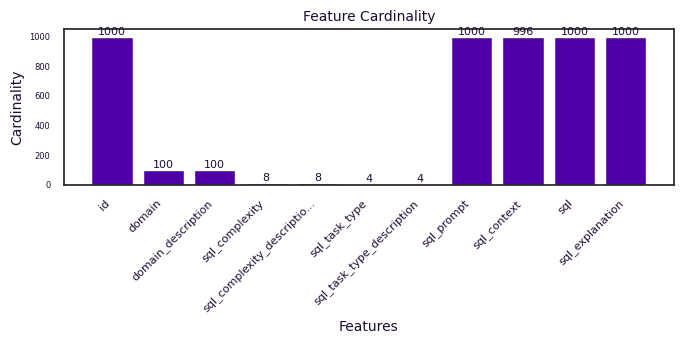

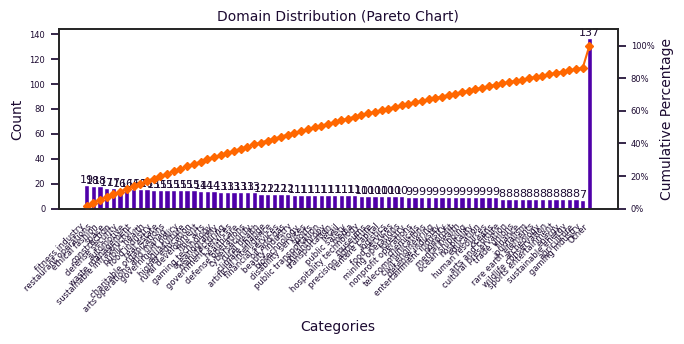

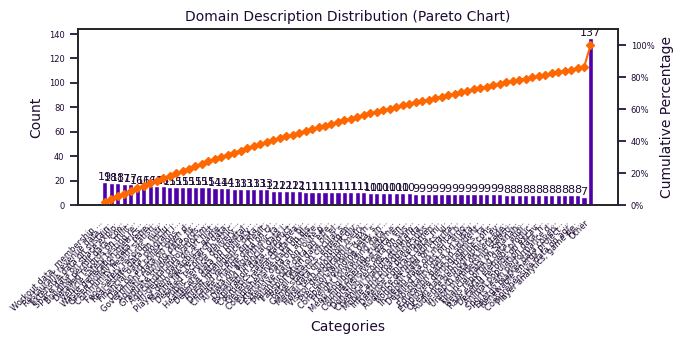

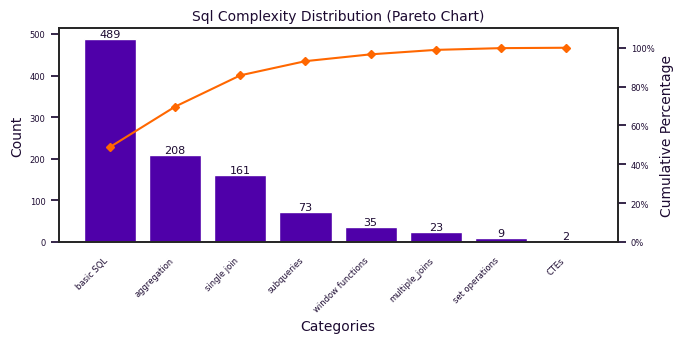

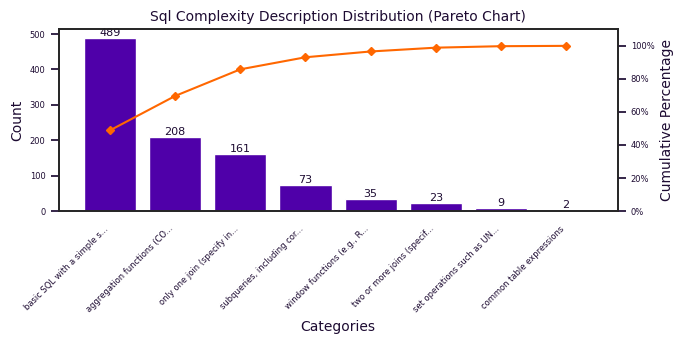

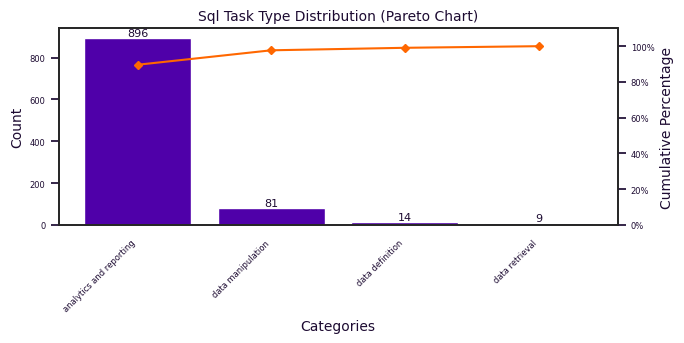

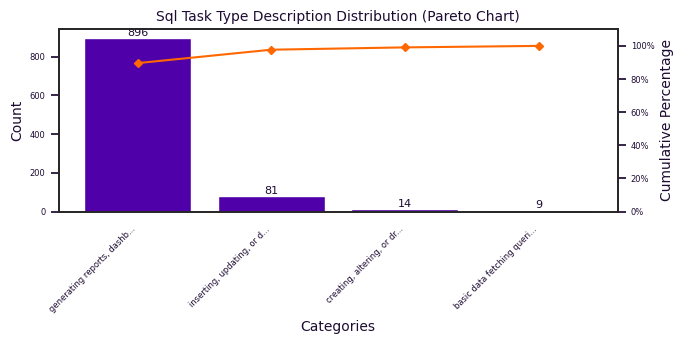

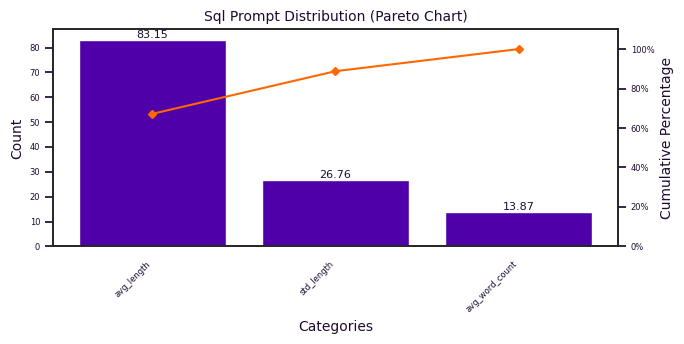

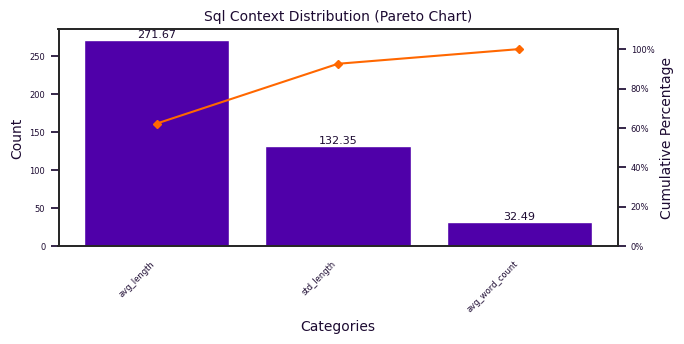

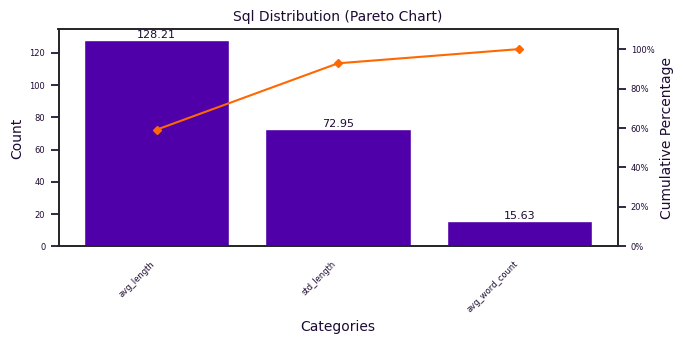

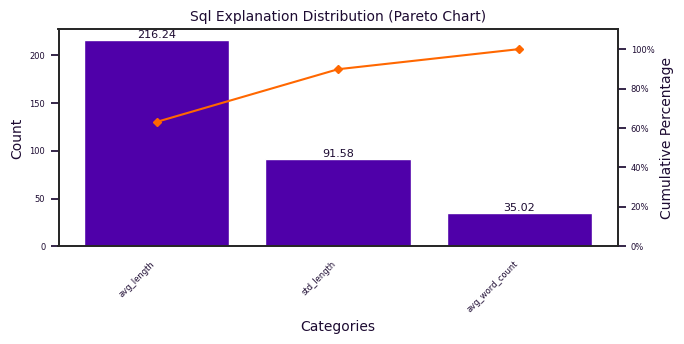

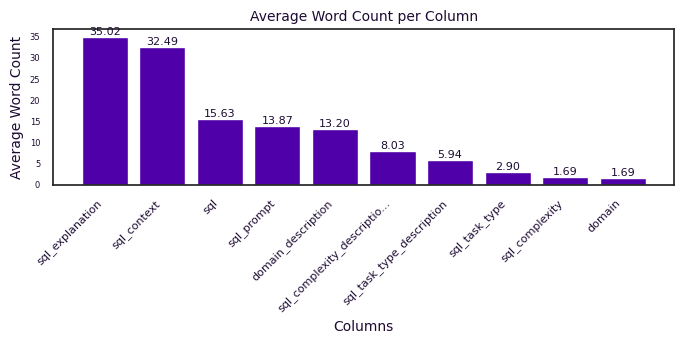

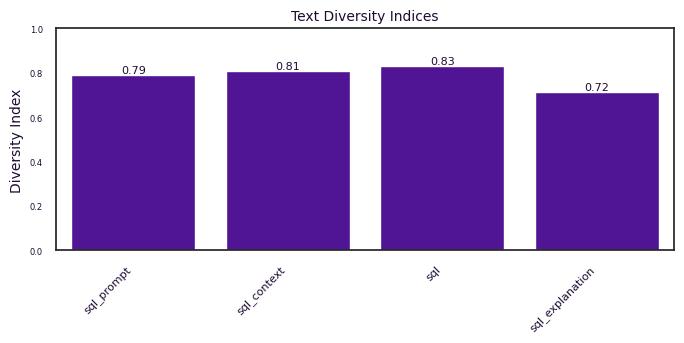

In [51]:
create_report_pdf(results, dataset_df,  'data_quality_report.pdf')